# 02 - Baseline VAE Training

This notebook covers:
1. Loading preprocessed data
2. Creating train/unseen splits and defining forget sets
3. VAE architecture (Encoder/Decoder with NB likelihood)
4. Training with KL annealing
5. Training curves and latent space visualization

In [37]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import scanpy as sc
import matplotlib.pyplot as plt
import json
from pathlib import Path
from sklearn.decomposition import PCA

from utils import set_global_seed, GLOBAL_SEED, DEVICE, Timer
from vae import VAE, vae_loss
from train import train_epoch, eval_epoch, get_kl_weight, create_dataloader

set_global_seed(GLOBAL_SEED)

DATA_DIR = Path('../data')
OUTPUT_DIR = Path('../outputs/p1/baseline')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Global seed: {GLOBAL_SEED}")
print(f"Device: {DEVICE}")

Global seed: 42
Device: cpu


## Create Splits

85/15 train/unseen split, then define structured forget set (Cluster 13) and scattered forget set (random).

In [38]:
adata = sc.read_h5ad(DATA_DIR / 'adata_processed.h5ad')
print(f"Loaded data: {adata.shape}")

# 85/15 train/unseen split (same logic as scripts/create_splits.py)
n_cells = adata.n_obs
n_train = int(0.85 * n_cells)

np.random.seed(GLOBAL_SEED)
indices = np.arange(n_cells)
np.random.shuffle(indices)

train_indices = indices[:n_train]
unseen_indices = indices[n_train:]

print(f"Train: {len(train_indices)}, Unseen: {len(unseen_indices)}")

Loaded data: (33088, 2000)
Train: 28124, Unseen: 4964


In [39]:
# Structured forget set: Cluster 13 (smallest cluster)
cluster_13_mask = adata.obs['leiden'] == '13'
cluster_13_indices = np.where(cluster_13_mask)[0]
forget_structured = np.intersect1d(cluster_13_indices, train_indices)
retain_structured = np.setdiff1d(train_indices, forget_structured)

print(f"Structured split:")
print(f"  Forget (Cluster 13): {len(forget_structured)}")
print(f"  Retain: {len(retain_structured)}")
print(f"  Unseen: {len(unseen_indices)}")

# Save structured split
split_structured = {
    'forget_indices': forget_structured.tolist(),
    'retain_indices': retain_structured.tolist(),
    'unseen_indices': unseen_indices.tolist(),
    'n_forget': int(len(forget_structured)),
    'n_retain': int(len(retain_structured)),
    'n_unseen': int(len(unseen_indices)),
    'description': 'Structured forget set: entire Cluster 13'
}

Path('../outputs/p1').mkdir(parents=True, exist_ok=True)
with open('../outputs/p1/split_structured.json', 'w') as f:
    json.dump(split_structured, f, indent=2)
print(f"Saved outputs/p1/split_structured.json")

# Scattered forget set: random 35 cells
np.random.seed(GLOBAL_SEED)
forget_scattered = np.random.choice(train_indices, size=35, replace=False)
retain_scattered = np.setdiff1d(train_indices, forget_scattered)

print(f"\nScattered split:")
print(f"  Forget (random): {len(forget_scattered)}")
print(f"  Retain: {len(retain_scattered)}")

split_scattered = {
    'forget_indices': forget_scattered.tolist(),
    'retain_indices': retain_scattered.tolist(),
    'unseen_indices': unseen_indices.tolist(),
    'n_forget': int(len(forget_scattered)),
    'n_retain': int(len(retain_scattered)),
    'n_unseen': int(len(unseen_indices)),
    'description': 'Scattered forget set: random 35 cells'
}

with open('../outputs/p1/split_scattered.json', 'w') as f:
    json.dump(split_scattered, f, indent=2)
print(f"Saved outputs/p1/split_scattered.json")

# Use structured split for training
split = split_structured
train_all = split['forget_indices'] + split['retain_indices']
print(f"\nTraining samples: {len(train_all)}")

Structured split:
  Forget (Cluster 13): 30
  Retain: 28094
  Unseen: 4964
Saved outputs/p1/split_structured.json

Scattered split:
  Forget (random): 35
  Retain: 28089
Saved outputs/p1/split_scattered.json

Training samples: 28124


## Create DataLoaders

In [40]:
BATCH_SIZE = 256

train_loader = create_dataloader(adata, train_all, batch_size=BATCH_SIZE, shuffle=True)

print(f"Train batches: {len(train_loader)}")

Train batches: 110


## Initialize VAE

Architecture:
- **Encoder**: input_dim → [1024, 512, 128] → z=32
- **Decoder**: z=32 → [128, 512, 1024] → input_dim
- **Likelihood**: Negative Binomial (for count data)
- **Regularization**: LayerNorm, Dropout=0.1

In [41]:
set_global_seed(GLOBAL_SEED)

config = {
    'input_dim': adata.n_vars,
    'hidden_dims': [1024, 512, 128],
    'latent_dim': 32,
    'likelihood': 'nb',
    'dropout': 0.1,
    'use_layer_norm': True,
    'lr': 1e-4,
    'epochs': 100,
    'batch_size': BATCH_SIZE,
    'kl_warmup_epochs': 20,
    'free_bits': 0.03,
    'early_stopping_patience': 10,
    'seed': GLOBAL_SEED
}

model = VAE(
    input_dim=config['input_dim'],
    hidden_dims=config['hidden_dims'],
    latent_dim=config['latent_dim'],
    likelihood=config['likelihood'],
    dropout=config['dropout'],
    use_layer_norm=config['use_layer_norm']
).to(DEVICE)

n_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {n_params:,}")
print(f"Architecture: {config['input_dim']} -> {config['hidden_dims']} -> z={config['latent_dim']}")

Model parameters: 7,349,984
Architecture: 2000 -> [1024, 512, 128] -> z=32


## Training Loop

In [42]:
optimizer = optim.Adam(model.parameters(), lr=config['lr'])

history = {
    'train_loss': [], 'train_recon': [], 'train_kl': [], 'kl_weight': []
}

best_train_loss = float('inf')
patience_counter = 0
print_every = 10
n_genes = config['input_dim']

print(f"Training for up to {config['epochs']} epochs (early stopping patience={config['early_stopping_patience']})")
print(f"KL warmup: {config['kl_warmup_epochs']} epochs, free bits: {config['free_bits']} nats/dim\n")

with Timer("Training"):
    for epoch in range(config['epochs']):
        kl_weight = get_kl_weight(epoch, config['kl_warmup_epochs'])
        
        train_metrics = train_epoch(
            model, train_loader, optimizer, DEVICE,
            likelihood=config['likelihood'],
            beta=kl_weight,
            free_bits=config['free_bits']
        )
        
        history['train_loss'].append(train_metrics['loss'])
        history['train_recon'].append(train_metrics['recon'])
        history['train_kl'].append(train_metrics['kl'])
        history['kl_weight'].append(kl_weight)
        
        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch+1:3d}/{config['epochs']} | "
                  f"Loss: {train_metrics['loss']:.1f} ({train_metrics['loss']/n_genes:.3f}/gene) | "
                  f"KL weight: {kl_weight:.2f}")
        
        if train_metrics['loss'] < best_train_loss:
            best_train_loss = train_metrics['loss']
            patience_counter = 0
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_metrics['loss'],
                'config': config
            }
            torch.save(checkpoint, OUTPUT_DIR / 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= config['early_stopping_patience']:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

print(f"\nBest train loss: {best_train_loss:.2f} ({best_train_loss/n_genes:.3f}/gene)")
print(f"Stopped at epoch {len(history['train_loss'])}")

Training for up to 100 epochs (early stopping patience=10)
KL warmup: 20 epochs, free bits: 0.03 nats/dim

[Training] Starting at 22:28:58
Epoch  10/100 | Loss: 380.4 (0.190/gene) | KL weight: 0.45
Epoch  20/100 | Loss: 379.1 (0.190/gene) | KL weight: 0.95
Epoch  30/100 | Loss: 375.9 (0.188/gene) | KL weight: 1.00
Epoch  40/100 | Loss: 373.2 (0.187/gene) | KL weight: 1.00
Epoch  50/100 | Loss: 371.2 (0.186/gene) | KL weight: 1.00
Epoch  60/100 | Loss: 369.7 (0.185/gene) | KL weight: 1.00
Epoch  70/100 | Loss: 368.5 (0.184/gene) | KL weight: 1.00
Epoch  80/100 | Loss: 367.6 (0.184/gene) | KL weight: 1.00
Epoch  90/100 | Loss: 366.8 (0.183/gene) | KL weight: 1.00
Epoch 100/100 | Loss: 366.3 (0.183/gene) | KL weight: 1.00
[Training] Completed in 847.92 seconds

Best train loss: 366.18 (0.183/gene)
Stopped at epoch 100


In [43]:
# Save training history
with open(OUTPUT_DIR / 'training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

print(f"Saved training history to {OUTPUT_DIR / 'training_history.json'}")

Saved training history to ../outputs/p1/baseline/training_history.json


## Training Curves

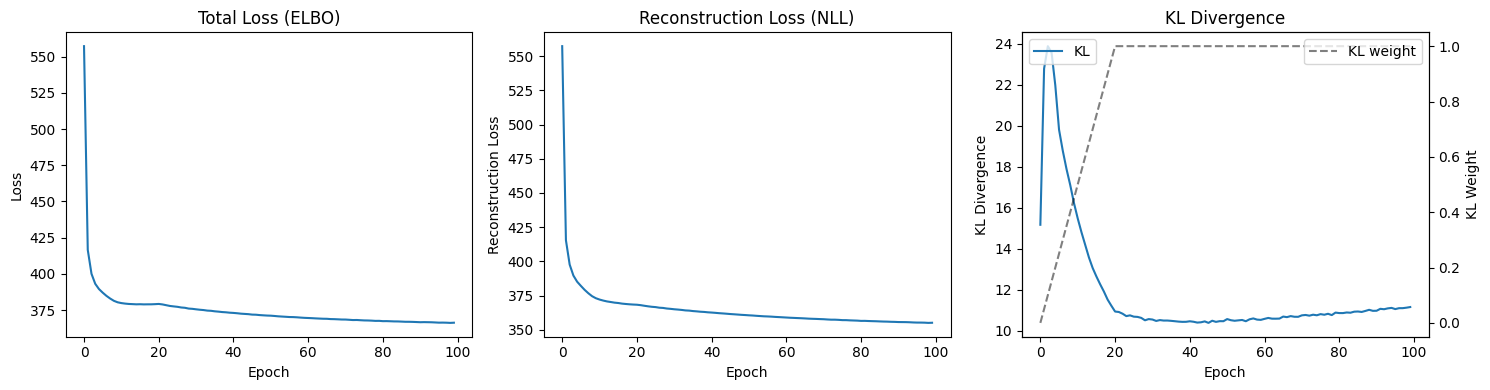

Final loss: 366.30


In [44]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['train_loss'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Total Loss (ELBO)')

axes[1].plot(history['train_recon'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Reconstruction Loss')
axes[1].set_title('Reconstruction Loss (NLL)')

axes[2].plot(history['train_kl'], label='KL')
ax2 = axes[2].twinx()
ax2.plot(history['kl_weight'], 'k--', alpha=0.5, label='KL weight')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('KL Divergence')
ax2.set_ylabel('KL Weight')
axes[2].set_title('KL Divergence')
axes[2].legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Final loss: {history['train_loss'][-1]:.2f}")

## Latent Space Visualization

In [45]:
# Load best model
checkpoint = torch.load(OUTPUT_DIR / 'best_model.pt', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Encode all cells
X = adata.X
if hasattr(X, 'toarray'):
    X = X.toarray()
x_tensor = torch.FloatTensor(X).to(DEVICE)

with torch.no_grad():
    mu, logvar = model.encode(x_tensor)
    z = mu.cpu().numpy()

print(f"Latent embeddings shape: {z.shape}")

Latent embeddings shape: (33088, 32)


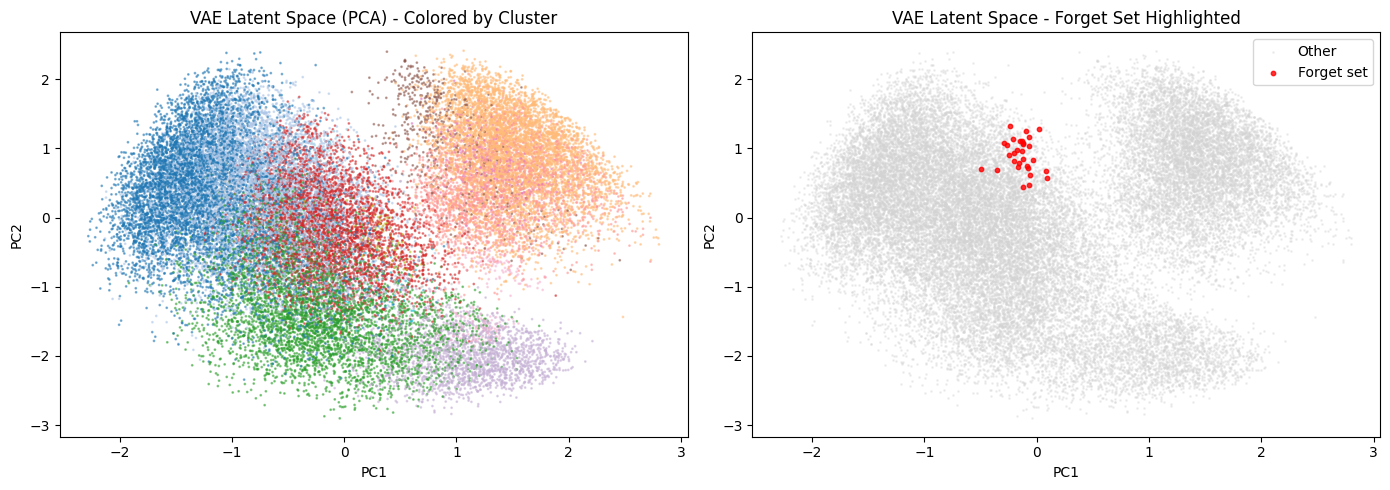

PCA variance explained: 27.9%


In [46]:
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

scatter = axes[0].scatter(z_pca[:, 0], z_pca[:, 1], 
                          c=adata.obs['leiden'].astype(int), 
                          cmap='tab20', s=1, alpha=0.5)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('VAE Latent Space (PCA) - Colored by Cluster')

forget_mask = np.zeros(adata.n_obs, dtype=bool)
forget_mask[split['forget_indices']] = True

axes[1].scatter(z_pca[~forget_mask, 0], z_pca[~forget_mask, 1], 
                c='lightgray', s=1, alpha=0.3, label='Other')
axes[1].scatter(z_pca[forget_mask, 0], z_pca[forget_mask, 1], 
                c='red', s=10, alpha=0.8, label='Forget set')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('VAE Latent Space - Forget Set Highlighted')
axes[1].legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'latent_space.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"PCA variance explained: {pca.explained_variance_ratio_.sum():.1%}")

## Summary

| Output | Path |
|--------|------|
| Structured split | `outputs/p1/split_structured.json` |
| Scattered split | `outputs/p1/split_scattered.json` |
| Best model checkpoint | `outputs/p1/baseline/best_model.pt` |
| Training history | `outputs/p1/baseline/training_history.json` |
| Training curves | `outputs/p1/baseline/training_curves.png` |
| Latent space viz | `outputs/p1/baseline/latent_space.png` |

**Next**: `03_privacy_audit.ipynb` - Train MIA attackers and assess baseline privacy leakage